# Predicción y análisis estratégico de ventas de mermeladas
## Modelado supervisado con `XGBoost` y `LightGBM`
## Objetivo
Predecir una variable continua (ej. ventas, demanda, ingresos) usando algoritmos de boosting. El enfoque sera estructurado, desde EDA hasta exportación del modelo.

### 1. Definicion del problema
#### Requerimiento 1
* Agrupar por `sabor` y calcular ventas totales por mes o trimestre
* Usar modelos de series de tiempo (ej. Prophet, LSTM) para proyectar ventas 5 años adelante
* Identificar el sabor con mayor crecimiento sostenido
#### Requerimiento 2
* Calcular ganancia acumulada por sabor
* Proyectar tendencia de ventas y ganancia
* Detectar sabores con ganancia actual pero caida proyectada

In [52]:
# Importo Librerias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#### En este caso generó un dataset sintetico enriquecido con `pandas` y `numpy`

In [53]:
np.random.seed(42)
# Parámetros base

fechas = pd.date_range(start = '2023-01-01', periods = 730, freq = 'D') # 2 años

sucursales = ['Centro','Norte','Sur','Este','Oeste']
promociones = ['Si','No']
sabores = ['Fresa','Mango','Uva','Melon','Durazno','Piña','Sandia']

# Simulación

df = pd.DataFrame({
    'fecha': np.random.choice(fechas, size = 5000),
    'sucursal': np.random.choice(sucursales, size = 5000),
    'promocion': np.random.choice(promociones, size = 5000),
    'sabor': np.random.choice(sabores, size = 5000),
    'ventas': np.random.poisson(lam = 20, size = 5000)
})

# Precios y costos por sabor

precios = {'Fresa': 25, 'Mango': 27, 'Uva': 26, 'Melon': 24, 'Durazno': 28, 'Piña': 23, ' Sandia': 22}
costos = {'Fresa': 15, 'Mango': 16, 'Uva': 14, 'Melon': 13, 'Durazno': 17, 'Piña': 12, ' Sandia': 11}

df['precio_unitario'] = df['sabor'].map(precios)
df['costo_unitario'] = df['sabor'].map(costos)
df['ganancia'] = (df['precio_unitario'] - df['costo_unitario']) * df['ventas']

# Genero el csv

df.to_csv('Data/ventas_mermeladas_enriquecido.csv', index = False)

#### 2. Carga y exploracion de datos (Recoleccion y comprension de datos)

In [54]:
# Cargo la data
df = pd.read_csv('Data/ventas_mermeladas_enriquecido.csv')

print(df.head())
print(df.info())
print(df.describe())

        fecha sucursal promocion    sabor  ventas  precio_unitario  \
0  2023-04-13    Norte        Si     Piña      24             23.0   
1  2024-03-11      Sur        Si  Durazno      20             28.0   
2  2023-09-28     Este        Si    Fresa      13             25.0   
3  2023-04-17    Oeste        No    Melon      17             24.0   
4  2023-03-13    Norte        Si    Fresa      21             25.0   

   costo_unitario  ganancia  
0            12.0     264.0  
1            17.0     220.0  
2            15.0     130.0  
3            13.0     187.0  
4            15.0     210.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   fecha            5000 non-null   object 
 1   sucursal         5000 non-null   object 
 2   promocion        5000 non-null   object 
 3   sabor            5000 non-null   object 
 4   ventas      

In [55]:
# Paso fecha a formato de fecha
df['fecha'] = pd.to_datetime(df['fecha'])

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   fecha            5000 non-null   datetime64[ns]
 1   sucursal         5000 non-null   object        
 2   promocion        5000 non-null   object        
 3   sabor            5000 non-null   object        
 4   ventas           5000 non-null   int64         
 5   precio_unitario  4228 non-null   float64       
 6   costo_unitario   4228 non-null   float64       
 7   ganancia         4228 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(3)
memory usage: 312.6+ KB
None


#### 3. Limpieza y transformación

In [56]:

df.dropna(subset = ['ventas','ganancia'], inplace = True)
df['dia_semana'] = df['fecha'].dt.dayofweek
df['mes'] = df['fecha'].dt.month
df['año'] = df['fecha'].dt.year
df['es_fin_de_semana'] = df['dia_semana'].apply(lambda x: 1 if x >= 5 else 0) # df['dia_semana'].isin([5,6])

#### 4. Feature engineering

In [57]:
# Conservo la columna original para análisis estratégico
df['sabor_original'] = df['sabor']

# Creo un nuevo DataFrame para modelado
df_modelado = pd.get_dummies(df, columns=['sucursal', 'promocion', 'sabor'], drop_first=True)

#### 5. Selección de variables

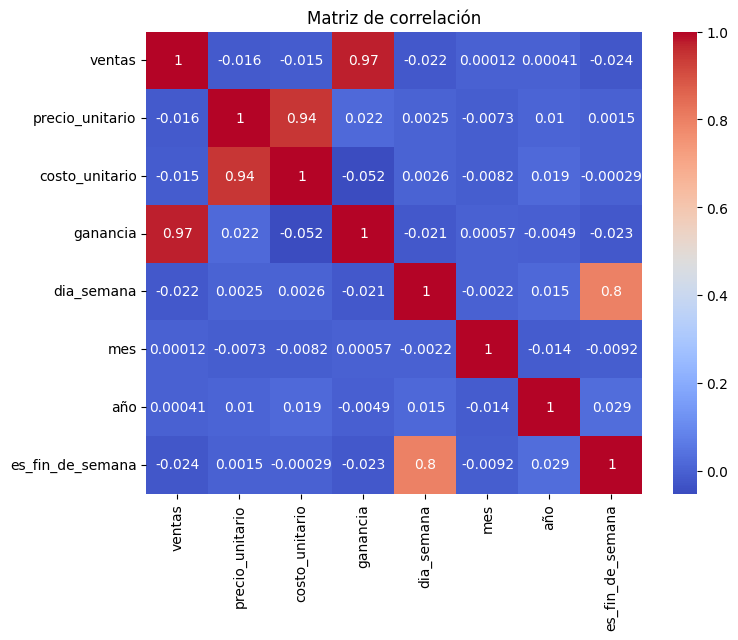

In [60]:
corr = df.corr(numeric_only = True)
plt.figure(figsize = (8,6))
sns.heatmap(corr, annot = True, cmap = 'coolwarm')
plt.title('Matriz de correlación')
plt.show()

#### 6. Modelado con XGBoost y LightGBM

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

X = df_modelado.drop(['ventas', 'ganancia', 'fecha', 'sabor_original'], axis=1)
y = df_modelado['ventas']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

model_xgb = XGBRegressor()
model_lgbm = LGBMRegressor()

model_xgb.fit(X_train, y_train)
model_lgbm.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59
[LightGBM] [Info] Number of data points in the train set: 3382, number of used features: 16
[LightGBM] [Info] Start training from score 20.009462


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


#### 7. Evaluación

In [62]:
y_pred_xgb = model_xgb.predict(X_test)
y_pred_lgbm = model_lgbm.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

rmse_lgbm = np.sqrt(mean_squared_error(y_test, y_pred_lgbm))
r2_lgbm = r2_score(y_test, y_pred_lgbm)

print(f'XGBoost: RMSE = {rmse_xgb:.2f}, R2 = {r2_xgb:.2f}')
print(f'LightGBM: RMSE = {rmse_lgbm:.2f}, R2 = {r2_lgbm:.2f}')

XGBoost: RMSE = 5.10, R2 = -0.32
LightGBM: RMSE = 4.55, R2 = -0.05


#### 8. Visualización de resultados

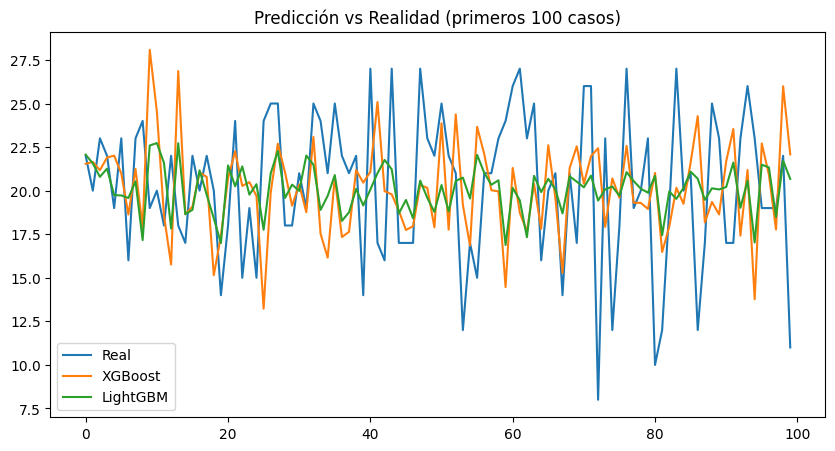

In [63]:
plt.figure(figsize=(10,5))
plt.plot(y_test.values[:100], label = 'Real')
plt.plot(y_pred_xgb[:100], label = 'XGBoost')
plt.plot(y_pred_lgbm[:100], label = 'LightGBM')
plt.legend()
plt.title('Predicción vs Realidad (primeros 100 casos)')
plt.show()

#### 9. Exportación del modelo

In [64]:
import joblib

joblib.dump(model_xgb, 'Modelos/modelo_xgb.pkl')
joblib.dump(model_lgbm, 'Modelos/modelo_lgbm.pkl')

['Modelos/modelo_lgbm.pkl']

#### 10. Respuesta a las preguntas del cliente

Pregunta 1: ¿Qué mermelada se vende más y se espera que siga siendo el top 1?

In [65]:
ventas_por_sabor = df.groupby('sabor_original')['ventas'].sum().sort_values(ascending=False)
ganancia_por_sabor = df.groupby('sabor_original')['ganancia'].sum().sort_values(ascending=False)
print("Ventas totales por sabor:\n", ventas_por_sabor)

# Proyección simple: promedio mensual por sabor
df['mes_año'] = df['fecha'].dt.to_period('M')
ventas_mensuales = df.groupby(['mes_año', 'sabor_original'])['ventas'].sum().reset_index()
ganancia_mensual = df.groupby(['mes_año', 'sabor_original'])['ganancia'].sum().reset_index()


# Aquí se puede incluir Prophet o extrapolación lineal para proyectar 5 años adelante

Ventas totales por sabor:
 sabor_original
Melon      14503
Piña       14332
Mango      14269
Durazno    14087
Fresa      14071
Uva        13499
Name: ventas, dtype: int64
